 n_estimators:  100  the root mean squared error is  0.0950069661519
 n_estimators:  106  the root mean squared error is  0.0949513372869
 n_estimators:  111  the root mean squared error is  0.0948116000436
 n_estimators:  137  the root mean squared error is  0.0946851677902
[ 2.55189872  1.73976335  1.80337186 ...,  4.7277791   4.51998062
  4.18825509]
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 137, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': None}
(0.7598, 'hour')
(0.0649, 'temp')
(0.0593, 'workingday')
(0.0389, 'month')
(0.0318, 'humidity')
(0.0192, 'windspeed')
(0.0127, 'weather')
(0.0111, 'season')
(0.0022, 'holiday')


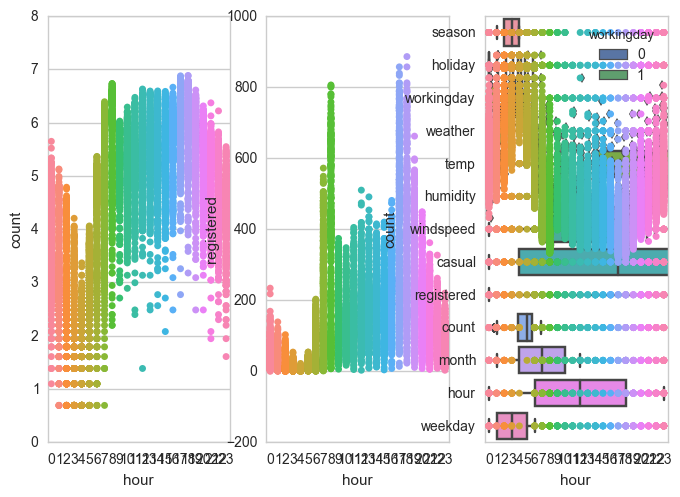

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
import random
get_ipython().magic(u'matplotlib inline')
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt, log

INPUT_FILE = 'bike_sharing_train.csv'
df = pd.read_csv(INPUT_FILE)


def preprocessing(df1, train=True):
    #extract the month and hour from date
    df1.datetime = df1.datetime.apply(pd.to_datetime)
    df1['month'] = df1.datetime.apply(lambda x : x.month)
    df1['hour'] = df1.datetime.apply(lambda x : x.hour)
    df1['date'] = df1['datetime'].dt.date
    df1['weekday'] = df1.datetime.apply(lambda x : x.dayofweek)
    cols_to_drop = ['datetime', 'date', 'atemp']
    categorical_cols = ['season', 'holiday', 'workingday', 'weather', 'weekday', 'hour', 'month']
    numerical_cols = ['temp', 'humidity', 'windspeed']
    for i in categorical_cols:
        df1[i] = df1[i].astype('category')
    for i in categorical_cols:
        df1[i] = df1[i].astype('category')
    df1 = df1.drop(cols_to_drop, axis = 1)
    if train:
        df1['count'] = df1['count'].apply(lambda x: np.log(x+1))
    return df1


df = preprocessing(df)

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))


# In[488]:

fig, axs = plt.subplots(ncols=3)
sns.stripplot(x="hour", y="count", data=df, ax=axs[0])
sns.stripplot(x="hour", y="registered", data=df, ax=axs[1])
sns.stripplot(x="hour", y="casual", data=df, ax=axs[2])
sns.stripplot(x="hour", y="count", data=df)
sns.boxplot(x="hour", y="count", hue="workingday", data=df);
sns.boxplot(data=df, orient="h");

df = df.drop(['casual', 'registered'], axis = 1)


cols = ['season', 'month','holiday','workingday' ,'weather', 'temp', 'humidity', 'windspeed', 'hour', 'count']
df = df.loc[:, cols]   

train, test = train_test_split(df, test_size = 0.3)

features = ['season', 'month','holiday','workingday' ,'weather', 'temp','hour', 'windspeed','humidity']

X_train, Y_train = train.loc[:, features], train.loc[:, 'count']
X_test, Y_test = test.loc[:, features], test.loc[:, 'count']

# In[494]:

def rmsle(predicted, actual):
    error = 0
    for i in range(len(actual)):
        error += pow(log(actual[i]+1)-log(predicted[i]+1), 2)
    return sqrt(error/len(actual))


#random.seed(743)
max_metric = 1000000000000
from sklearn.ensemble import RandomForestRegressor
for j in range(100, 150):
    regressor = RandomForestRegressor(n_estimators = j)
    regressor.fit(X_train, Y_train)
    pred = regressor.predict(X_test)
    metric  = rmsle(pred.tolist(), Y_test.tolist())
    if metric < max_metric:
        max_metric = metric
        model = regressor
        print " n_estimators: ", j, " the root mean squared error is ", metric


OUTPUT_FILE = 'test.csv'
df_op = pd.read_csv(OUTPUT_FILE)
df_op = preprocessing(df_op, False)
features = ['season', 'month','holiday','workingday' ,'weather', 'temp', 'hour','windspeed','humidity']
X_test = df_op.loc[:, features]
pred = model.predict(X_test)
print pred

OUTPUT_FILE = 'test.csv'
df_op = pd.read_csv(OUTPUT_FILE)
df_op['count'] = np.exp(pred)-1
desred_decimals = 0
df_op['count'] = df_op['count'].astype('int64')
#df_op['count'] = df_op['count'].apply(lambda x: round(x,desred_decimals))
df_op = df_op.loc[:, ['datetime', 'count']]
df_op.head()

df_op.to_csv('submissions.csv',index = False)

df_op.shape

featues_importance = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), features), reverse=True)
print model.get_params()
for i in featues_importance:
    print i


